In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta

import anomaly_detection as ao

sns.set()

In [6]:
def run_anomalies(df, run_date, social_mod=None,
                  limit=95, horizon=12, simulations=10):   

    all_forcs = ao.anomaly_wrapper(df, run_date, horizon,
                                   simulations=simulations,
                                   social_mod=social_mod)

    forcs_df = (all_forcs.groupby(['region', 'cutoff', 'ds'])
                ['percent_ill']
                .describe(percentiles=[.025, 0.05, .1, .25, .5, .75, .9, .95, .975])
                .reset_index())

    # Be sure to grab the correct percentile...
    limit_dict = {90: '95%', 95: '97.5%'}

    forcs_df = forcs_df.merge(df[['region', 'percent_ill', 'ds']],
                              on=['region', 'ds'], how='outer')

    forcs_df['anomaly_diff'] = (forcs_df['percent_ill']
                                - forcs_df[limit_dict[limit]])
    forcs_df['anomaly_ili'] = np.where(forcs_df['anomaly_diff'] > 0,
                                       forcs_df['percent_ill'], np.nan)

    # Only keep the significant anomaly differences
    forcs_df['anomaly_diff'] = (forcs_df['anomaly_ili'] -
                                forcs_df[limit_dict[limit]])
    forcs_df['anomaly_diff'] = forcs_df['anomaly_diff'].fillna(0)
    
    return forcs_df


In [7]:
# Create the Brooklyn, NY ensemble forecasting and anomaly detection example...
ili_df = pd.read_csv('kings_ny.csv')
ili_df['ds'] = pd.to_datetime(ili_df['date'])
ili_df['doy'] = ili_df.ds.dt.dayofyear

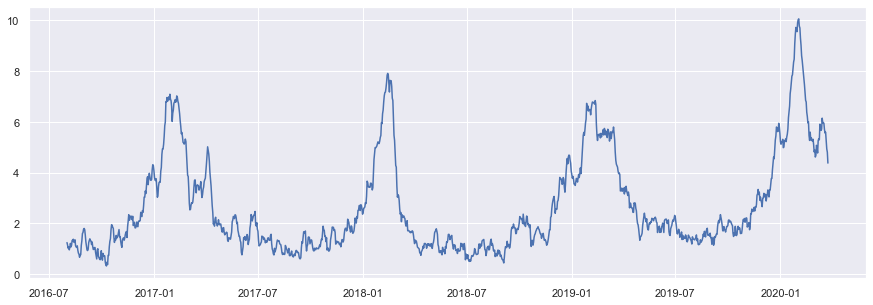

In [8]:
plt.figure(figsize=(15, 5))
plt.plot(ili_df['ds'], ili_df['percent_ill'])

In [9]:
test = run_anomalies(ili_df, ['2020-03-01'], simulations=100)

Forecasting for 36047


/Users/samchamberlain/.local/share/virtualenvs/therm_anomaly_detection-cYEoWQk6/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


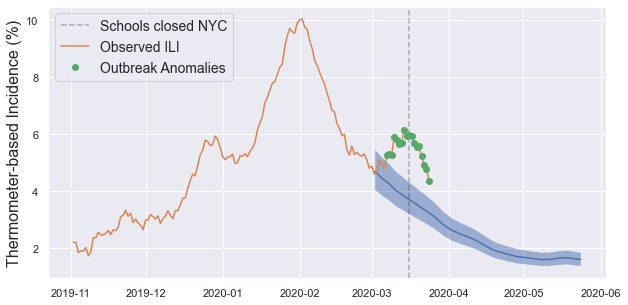

In [10]:
### Figure 1: Example detection in Brooklyn, NY
sub = test[test.ds > '2019-11-01'].copy()
sub.sort_values('ds', inplace=True)

plt.figure(figsize=(10, 5))
plt.axvline(pd.to_datetime('2020-03-16'), color='k', linestyle='--', alpha=0.3, label='Schools closed NYC')
plt.fill_between(sub.ds, sub['97.5%'], sub['2.5%'], alpha=0.5)
plt.plot(sub.ds, sub['50%'], label='')
plt.plot(sub.ds, sub.percent_ill, label='Observed ILI')
plt.plot(sub.ds, sub.anomaly_ili, '.', ms=12, label='Outbreak Anomalies')

plt.ylabel('Thermometer-based Incidence (%)', fontsize=16)
plt.legend(fontsize=14, loc='upper left')
plt.savefig('fig2.png', dpi=300)

In [11]:
test_distancing = run_anomalies(ili_df, ['2020-03-01'], social_mod=0.9, simulations=100)

Forecasting for 36047


/Users/samchamberlain/.local/share/virtualenvs/therm_anomaly_detection-cYEoWQk6/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


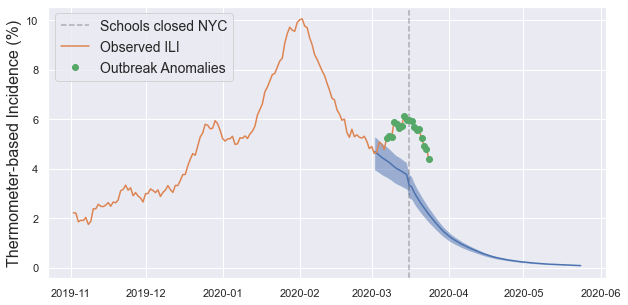

In [12]:
### Social distancing estimate
sub = test_distancing[test_distancing.ds > '2019-11-01'].copy()
sub.sort_values('ds', inplace=True)

plt.figure(figsize=(10, 5))
plt.axvline(pd.to_datetime('2020-03-16'), color='k', linestyle='--', alpha=0.3, label='Schools closed NYC')
plt.fill_between(sub.ds, sub['97.5%'], sub['2.5%'], alpha=0.5)
plt.plot(sub.ds, sub['50%'], label='')
plt.plot(sub.ds, sub.percent_ill, label='Observed ILI')
plt.plot(sub.ds, sub.anomaly_ili, '.', ms=12, label='Outbreak Anomalies')

plt.ylabel('Thermometer-based Incidence (%)', fontsize=16)
plt.legend(fontsize=14, loc='upper left')